# Using ConvoKit for conversational forecasting with the CRAFT backend

This notebook demonstrates how to use ConvoKit's `Forecaster` Transformer with the `CRAFTModel` backend to forecast future personal attacks in Wikipedia talk page conversations. In doing so, we will reproduce the results of the original CRAFT experiments as presented in the originating paper "Trouble on the Horizon: Forecasting the Derailment of Conversations as they Develop".

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from convokit import Forecaster, Corpus, download
from convokit.forecaster.CRAFTModel import CRAFTModel
from convokit.forecaster.CRAFT import craft_tokenize

We will be using ConvoKit's "conversations gone awry" corpus, which contains ground truth labels for personal attacks in each conversation. This is the same corpus used in the original paper.

In [2]:
corpus = Corpus(filename=download("conversations-gone-awry-corpus"))

Dataset already exists at /home/jonathan/.convokit/downloads/conversations-gone-awry-corpus


## Initializing the CRAFTModel backend

ConvoKit's `Forecaster` is a modular implementation of general forecasting behavior, meaning that it does not implement any specific forecasting algorithm and instead encapsulates the general behavior of iterating over a conversation and producing a forecast score upon each new comment (using some specified algorithm). Specific algorithm implementations are delegated to a class known as a `Model`. Therefore, before we can instantiate a `Forecaster`, we must first instantiate the `Model` we want to use. In this demo, we will use ConvoKit's implementation of the CRAFT algorithm, known as `CRAFTModel`.

In [3]:
# We define the constant DEVICE to specify whether we want to run in GPU mode or CPU mode. As CRAFT is a neural model, GPU mode
# (activated with the value "cuda") is preferred. But if your machine lacks a GPU, you can change the value to "cpu" to enable
# CPU mode (noting that it will be slower)
DEVICE = "cpu"

In [4]:
# initialize the CRAFTModel using the specified device
craft_model = CRAFTModel(device_type=DEVICE)

Initializing CRAFT model with options:
{'hidden_size': 500, 'encoder_n_layers': 2, 'context_encoder_n_layers': 2, 'decoder_n_layers': 2, 'dropout': 0.1, 'batch_size': 64, 'clip': 50.0, 'learning_rate': 1e-05, 'print_every': 10, 'train_epochs': 30, 'validation_size': 0.2, 'max_length': 80, 'trained_model_output_filepath': 'finetuned_model.tar'}
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!


## Corpus preprocessing

CRAFT was originally developed separately from ConvoKit and used a different tokenization scheme than ConvoKit's default. This could cause problems as ConvoKit's tokenization might produce tokens that are inconsistent with what CRAFT expects, potentially causing errors. ConvoKit ships with a workaround for this by offering CRAFT's tokenizer as the importable function `craft_tokenize`. We can use this function to tokenize the utterances in the corpus and add the resulting tokenization as metadata.

In [5]:
for utt in corpus.iter_utterances():
    utt.add_meta("tokens", craft_tokenize(craft_model.voc, utt.text))

## Initializing the Forecaster

We now have everything we need to initialize our instance of `Forecaster` with the previously created `CRAFTModel` as the backend. Note: please see [the docs](https://convokit.cornell.edu/documentation/forecaster.html) for a full explanation of what the other parameters besides `model` do.

In [6]:
MAX_LENGTH = 80  # this constant controls the maximum number of tokens to consider; it must be set to 80 since that's what CRAFT was trained one.
forecaster = Forecaster(
    forecaster_model=craft_model,
    forecast_mode="past",
    convo_structure="linear",
    text_func=lambda utt: utt.meta["tokens"][: (MAX_LENGTH - 1)],
    label_func=lambda utt: int(utt.meta["comment_has_personal_attack"]),
    forecast_attribute_name="prediction",
    forecast_prob_attribute_name="pred_score",
    use_last_only=False,
    skip_broken_convos=False,
)

## Running and evaluating the Forecaster

Now that we have our `Forecaster`, which follows ConvoKit's standard `Transformer` interface, actually doing conversational forecasting is as simple as calling `transform` on the corpus! Then, we can use the resulting annotations to evaluate the forecasts using the metrics defined in the paper, which include conversation-level versions of accuracy, precision, and recall.

In [7]:
# Annotate the test set. Note: the Conversations Gone Awry corpus contains some Utterance objects that are not actual
# comments, but rather the "section header" (something akin to a conversation title in Wikipedia talk pages). Since they
# are not real comments, we do not want to include them in forecasting. We use the ignore_utterances parameter to
# specify this behavior.
forecaster.transform(
    corpus,
    selector=lambda convo: convo.meta["split"] in ["test"],
    ignore_utterances=lambda utt: utt.meta["is_section_header"],
)

Iteration: 1; Percent complete: 1.4%
Iteration: 2; Percent complete: 2.9%
Iteration: 3; Percent complete: 4.3%
Iteration: 4; Percent complete: 5.8%
Iteration: 5; Percent complete: 7.2%
Iteration: 6; Percent complete: 8.7%
Iteration: 7; Percent complete: 10.1%
Iteration: 8; Percent complete: 11.6%
Iteration: 9; Percent complete: 13.0%
Iteration: 10; Percent complete: 14.5%
Iteration: 11; Percent complete: 15.9%
Iteration: 12; Percent complete: 17.4%
Iteration: 13; Percent complete: 18.8%
Iteration: 14; Percent complete: 20.3%
Iteration: 15; Percent complete: 21.7%
Iteration: 16; Percent complete: 23.2%
Iteration: 17; Percent complete: 24.6%
Iteration: 18; Percent complete: 26.1%
Iteration: 19; Percent complete: 27.5%
Iteration: 20; Percent complete: 29.0%
Iteration: 21; Percent complete: 30.4%
Iteration: 22; Percent complete: 31.9%
Iteration: 23; Percent complete: 33.3%
Iteration: 24; Percent complete: 34.8%
Iteration: 25; Percent complete: 36.2%
Iteration: 26; Percent complete: 37.7%
I

In [8]:
df = forecaster.summarize(corpus)

The `Forecaster` transformation gives us a forecast score for each utterance. In turn, this score can be converted into a binary
utterance-level decision by applying a threshold (the one we use here was tuned on a validation set). However, the ground truth
labels are not utterance level, but conversation level: either a conversation derails or it does not. 
Thus, correctness of a forecast decision at a conversation level is defined as follows:
  - True positives are cases that actually derail, for which the model made at least one positive forecast ANYTIME prior to derailment
  - False positives are cases that don't derail but for which the model made at least one positive forecast
  - False negatives are cases that derail but for which the model made no positive forecasts prior to derailment
  - True negatives are cases that don't derail, for which the model made no positive forecasts
  
Then, using these definitions, we can define accuracy, precision, and recall as standard in terms of true/false positives/negatives.

In [9]:
FORECAST_THRESH = 0.570617  # Threshold learned on a validation set. Try playing with this to see how it affects the precision-recall tradeoff!
preds = []
labels = []
# Iterate at a conversation level and consolidate predictions for each conversation
for convo in corpus.iter_conversations(selector=lambda c: c.meta["split"] == "test"):
    labels.append(int(convo.meta["conversation_has_personal_attack"]))
    prediction = 0
    for utt in convo.iter_utterances():
        if utt.meta["pred_score"] is not None and utt.meta["pred_score"] > FORECAST_THRESH:
            prediction = 1
    preds.append(prediction)
preds = np.asarray(preds)
labels = np.asarray(labels)

In [10]:
# Compute accuracy, precision, recall, F1, and false positive rate
acc = np.mean(preds == labels)
precision, recall, f1, _ = precision_recall_fscore_support(preds, labels, average="binary")
fpr = np.mean(preds[labels == 0])
print(
    "Accuracy = {:.2%}, Precision = {:.2%}, Recall = {:.2%}, FPR = {:.2%}, F1 = {:.2%}".format(
        acc, precision, recall, fpr, f1
    )
)

Accuracy = 66.43%, Precision = 77.38%, Recall = 63.48%, FPR = 44.52%, F1 = 69.74%


In addition to accuracy and other numerical metrics, the paper also included an experiment exploring how early in a conversation
the first correct positive forecast tends to occur. We repeat that analysis here:

In [11]:
comments_until_derail = (
    {}
)  # store the "number of comments until derailment" metric for each conversation

for convo in corpus.iter_conversations(
    selector=lambda c: c.meta["split"] == "test" and c.meta["conversation_has_personal_attack"]
):
    # filter out the section header as usual
    utts = [utt for utt in convo.iter_utterances() if not utt.meta["is_section_header"]]
    # by construction, the last comment is the one with the personal attack
    derail_idx = len(utts) - 1
    # now scan the utterances in order until we find the first derailment prediction (if any)
    for idx in range(1, len(utts)):
        if utts[idx].meta["pred_score"] > FORECAST_THRESH:
            # recall that the forecast_score meta field specifies what CRAFT thought this comment would look like BEFORE it
            # saw this comment. So the actual CRAFT forecast is made during the previous comment; we account for this by
            # subtracting 1 from idx
            comments_until_derail[convo.id] = derail_idx - (idx - 1)
            break

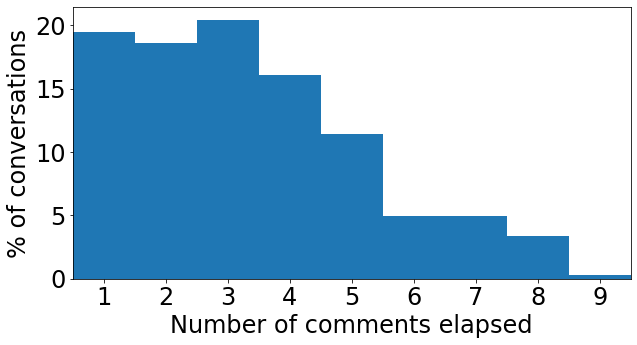

In [12]:
# visualize the distribution of "number of comments until derailment" as a histogram (reproducing Figure 4 from the paper)
comments_until_derail_vals = np.asarray(list(comments_until_derail.values()))
plt.rcParams["figure.figsize"] = (10.0, 5.0)
plt.rcParams["font.size"] = 24
plt.hist(
    comments_until_derail_vals, bins=range(1, np.max(comments_until_derail_vals)), density=True
)
plt.xlim(1, 10)
plt.xticks(np.arange(1, 10) + 0.5, np.arange(1, 10))
plt.yticks(np.arange(0, 0.25, 0.05), np.arange(0, 25, 5))
plt.xlabel("Number of comments elapsed")
plt.ylabel("% of conversations")
plt.show()